# generate_multitreatment_gamma_26()


`generate_multitreatment_gamma_26()` builds a **3-arm multi-treatment** observational DGP with correlated confounders and a Gamma outcome.

Treatment columns are one-hot: $D=(D_0,D_1,D_2)$ with exactly one active class per row (`d_0`, `d_1`, `d_2`).

The scenario is configured to target marginal treatment shares close to $(0.50, 0.25, 0.25)$.


## 1. Confounders and Dependence

The confounder vector is $X=(X_1,\dots,X_8)$ with marginals:

- $X_1$ (`tenure_months`) $\sim \mathcal{N}(24, 12^2)$, clipped to $[0,120]$
- $X_2$ (`avg_sessions_week`) $\sim \mathcal{N}(5, 2^2)$, clipped to $[0,40]$
- $X_3$ (`spend_last_month`) $\sim \text{LogNormal}(\log 60, 0.9)$, clipped at 500
- $X_4$ (`premium_user`) $\sim \text{Bernoulli}(0.25)$
- $X_5$ (`urban_resident`) $\sim \text{Bernoulli}(0.60)$
- $X_6$ (`support_tickets_q`) $\sim \text{Poisson}(1.5)$, clipped at 15
- $X_7$ (`discount_eligible`) $\sim \text{Bernoulli}(0.35)$
- $X_8$ (`credit_utilization`) $\sim \text{Beta}(\alpha,\beta)$ with mean $0.45$ and concentration $\kappa=20$

Dependence is induced with a Gaussian copula whose correlation matrix is Toeplitz:
$$\Sigma_{ij} = \rho^{|i-j|}, \quad \rho=0.30.$$


## 2. Treatment Assignment (Multinomial Logit)

For each class $k \in \{0,1,2\}$, define score
$$s_k(X) = \alpha_k + X^\top\beta_{d,k}.$$
Then propensity is softmax:
$$m_k(X)=P(D_k=1\mid X)=\frac{\exp(s_k(X))}{\sum_{j=0}^2\exp(s_j(X))}. $$

Coefficients used in this scenario:

- $\beta_{d,0}=\mathbf{0}$
- $\beta_{d,1}=[0.01, 0.10, 0.0015, 0.50, 0.20, 0.05, 0.35, 0.40]$
- $\beta_{d,2}=[-0.005, 0.07, 0.0010, 0.35, 0.10, 0.08, 0.20, 0.25]$

Treatment-score intercepts start at $(0.0,0.0,0.0)$, then are calibrated iteratively so mean class rates are close to target $(0.50,0.25,0.25)$.


## 3. Treatment Effects on Link Scale

The structural link shift for class $k$ is
$$\tau^{link}_k(X)=\theta_k+\tau_k(X), \qquad \theta=(0.0,-0.05,0.10).$$

Control has no heterogeneous residual: $\tau_0(X)=0$.

For `d_1` (forced harmful vs control):
$$\tau_1(X)=\min\Big(-0.22 -0.001\,\text{tenure}-0.006\,\text{sessions}-0.05\,\text{premium}-0.04\,\text{discount}-0.10(\text{credit}-0.45),\,-0.02\Big).$$

For `d_2` (forced beneficial vs control):
$$\tau_2(X)=\max\Big(0.16 +0.014\,\text{sessions}+0.030\log(1+\text{spend})+0.06\,\text{urban}-0.006\,\text{tickets}+0.12(\text{credit}-0.45),\,0.02\Big).$$


## 4. Outcome Model (Gamma)

Baseline linear predictor:
$$\eta_0(X)=\alpha_y + X^\top\beta_y, \qquad \alpha_y=0,$$
with
$$\beta_y=[0.01,0.08,0.0015,0.35,0.12,0.06,0.20,0.50].$$

Observed link for assigned treatment:
$$\eta(X,D)=\eta_0(X)+\sum_{k=0}^2 D_k\,\tau^{link}_k(X).$$

Gamma mean uses log link:
$$\mu(X,D)=\exp(\eta(X,D)).$$
Given shape $a=2.0$, outcome is sampled as
$$Y\mid X,D \sim \text{Gamma}(\text{shape}=a,\,\text{scale}=\mu/a),$$
so $\mathbb{E}[Y\mid X,D]=\mu$ and $\mathrm{Var}(Y\mid X,D)=\mu^2/a$.


## 5. Oracle Quantities

When `include_oracle=True`, the generator exposes:

- `m_d_0`, `m_d_1`, `m_d_2`: calibrated propensities $m_k(X)$
- `tau_link_d_k`: link-scale treatment shifts $\tau^{link}_k(X)$
- `g_d_k`: potential outcome means on natural scale under class $k$
- `cate_d_1 = g_{d_1}-g_{d_0}`, `cate_d_2 = g_{d_2}-g_{d_0}`


In [1]:
from causalis.data_contracts import MultiCausalData
from causalis.scenarios.multi_unconfoundedness.dgp import generate_multitreatment_gamma_26

df = generate_multitreatment_gamma_26(
    seed=42,
    include_oracle=True,
    return_causal_data=False,
)

df.head()


,y,d_0,d_1,d_2,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident,support_tickets_q,...,m_obs_d_1,tau_link_d_1,m_d_2,m_obs_d_2,tau_link_d_2,g_d_0,g_d_1,g_d_2,cate_d_1,cate_d_2
0,0.422769,1.0,0.0,0.0,27.656605,3.198667,89.609464,0.0,1.0,0.0,...,0.246687,-0.352005,0.220781,0.220781,0.494166,3.279384,2.306314,5.375338,-0.973070,2.095954
1,7.566231,1.0,0.0,0.0,23.798386,3.362415,102.337236,0.0,0.0,3.0,...,0.179393,-0.307360,0.236958,0.236958,0.420278,2.807850,2.064853,4.274630,-0.742997,1.466780
2,1.702662,0.0,0.0,1.0,28.425009,3.391819,102.660712,0.0,1.0,1.0,...,0.210566,-0.320189,0.218245,0.218245,0.502415,3.069919,2.228798,5.073677,-0.841121,2.003758
3,1.827530,1.0,0.0,0.0,18.860066,4.071175,83.593417,0.0,0.0,2.0,...,0.176729,-0.316241,0.237639,0.237639,0.441677,2.716805,1.980234,4.225485,-0.736571,1.508680
4,1.429843,0.0,1.0,0.0,17.853087,3.140075,79.209870,0.0,1.0,1.0,...,0.232492,-0.350130,0.247027,0.247027,0.493624,3.224354,2.271869,5.282273,-0.952485,2.057919


In [2]:
print(f"Ground truth ATE for d_1 vs d_0 is {df['cate_d_1'].mean()}")
print(f"Ground truth ATE for d_2 vs d_0 is {df['cate_d_2'].mean()}")

Ground truth ATE for d_1 vs d_0 is -1.1950325692907122
Ground truth ATE for d_2 vs d_0 is 2.530398527003894


In [3]:
# wrap it in CausalData
from causalis.data_contracts.multicausaldata import MultiCausalData
multi_causaldata = MultiCausalData(df = df,
                        treatment_names=['d_0', 'd_1', 'd_2'],
                        control_treatment= 'd_0',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'premium_user',
                                     'urban_resident',
                                     'support_tickets_q',
                                     'discount_eligible',
                                     'credit_utilization'])
multi_causaldata

MultiCausalData(df=(100000, 12), treatment_names=['d_0', 'd_1', 'd_2'], control_treatment='d_0')outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'premium_user', 'urban_resident', 'support_tickets_q', 'discount_eligible', 'credit_utilization'], user_id=None, 

In [4]:
from causalis.shared.outcome_stats import outcome_stats
outcome_stats(multi_causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,d_0,50115,3.758417,3.106725,0.015427,0.887906,1.626326,2.937863,4.957415,7.577785,50.239323
1,d_2,25008,6.541717,5.539708,0.043125,1.512610,2.775637,5.102611,8.584913,13.348761,79.125235
2,d_1,24877,2.980817,2.412763,0.009022,0.711997,1.306774,2.352234,3.946463,5.985070,25.169272


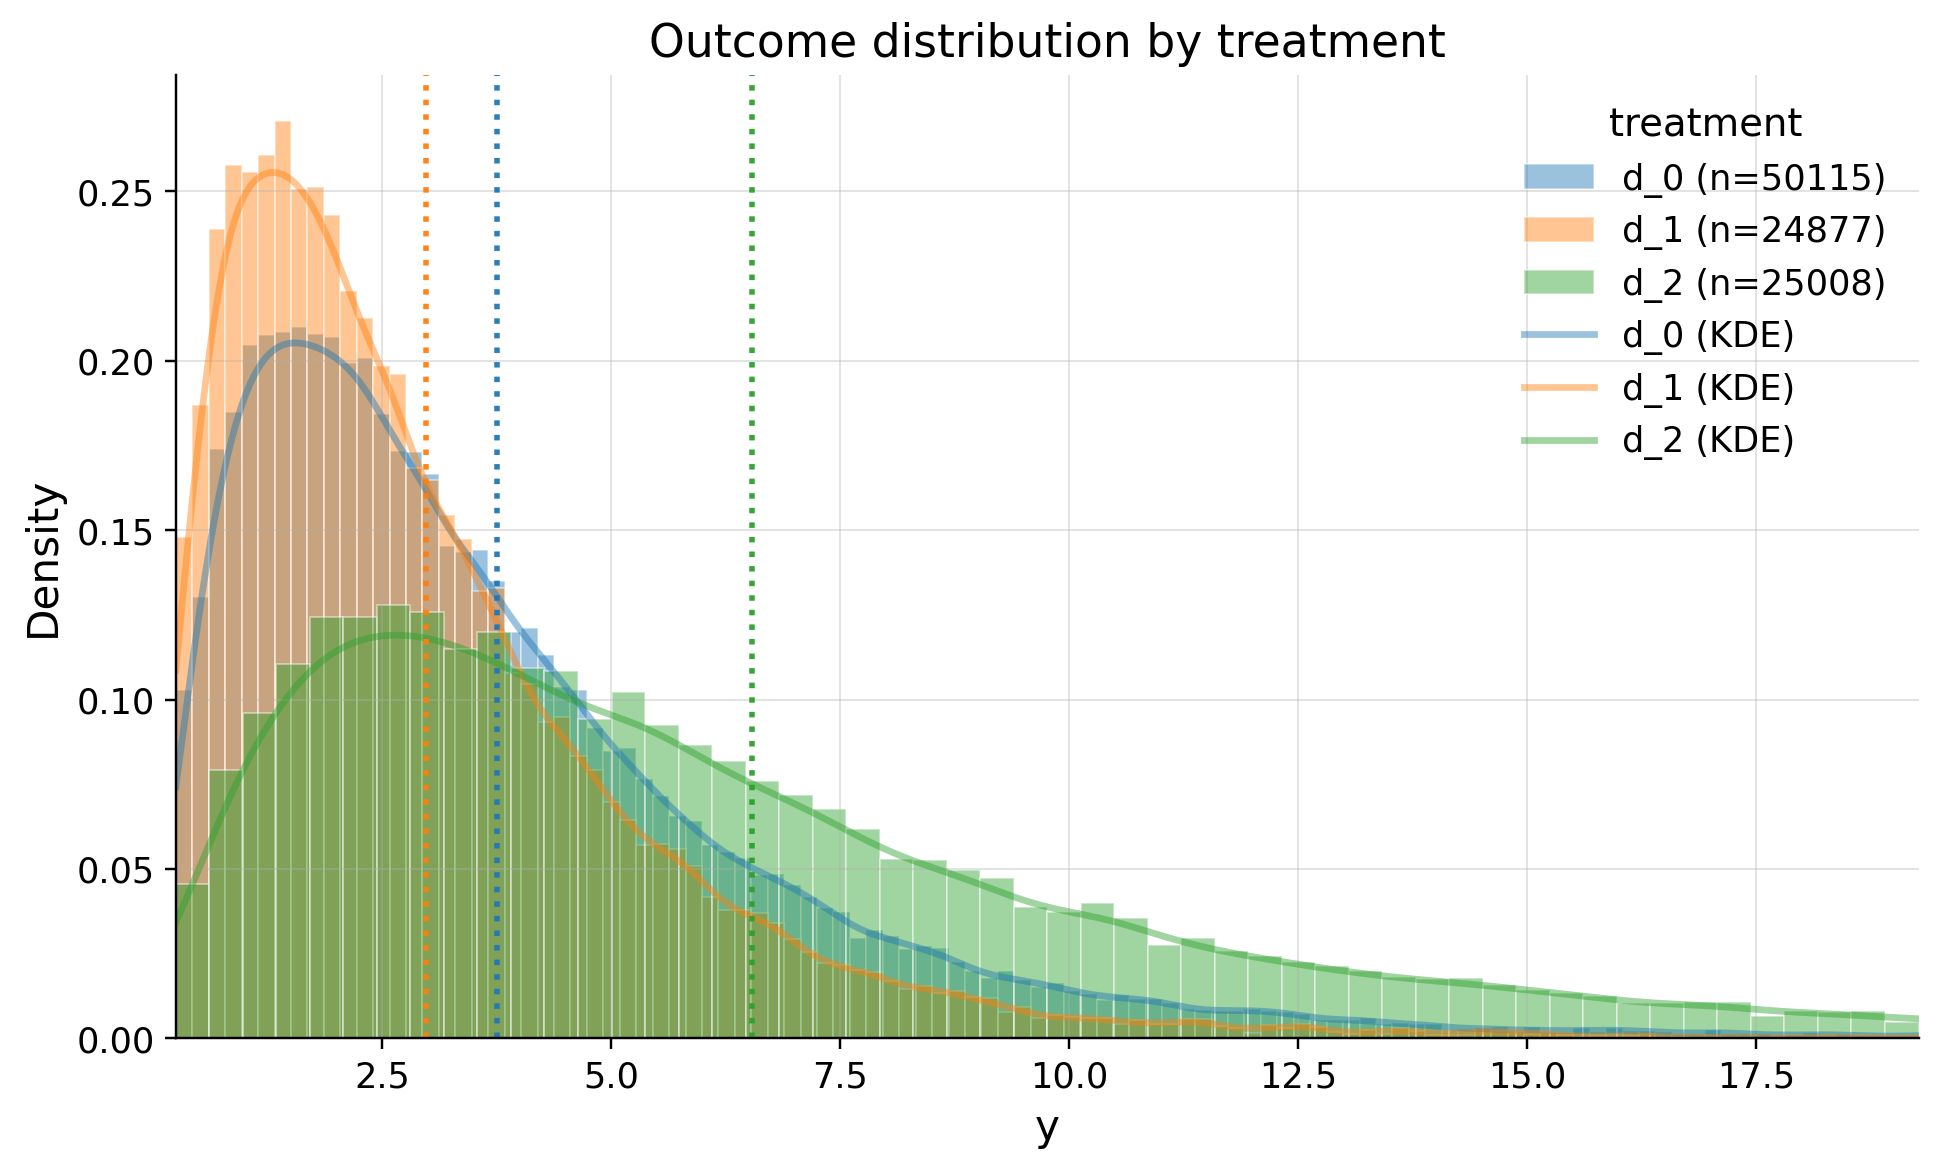

In [5]:
# Statistics for outcome comparison
from causalis.shared import outcome_plot_dist

outcome_plot_dist(multi_causaldata)

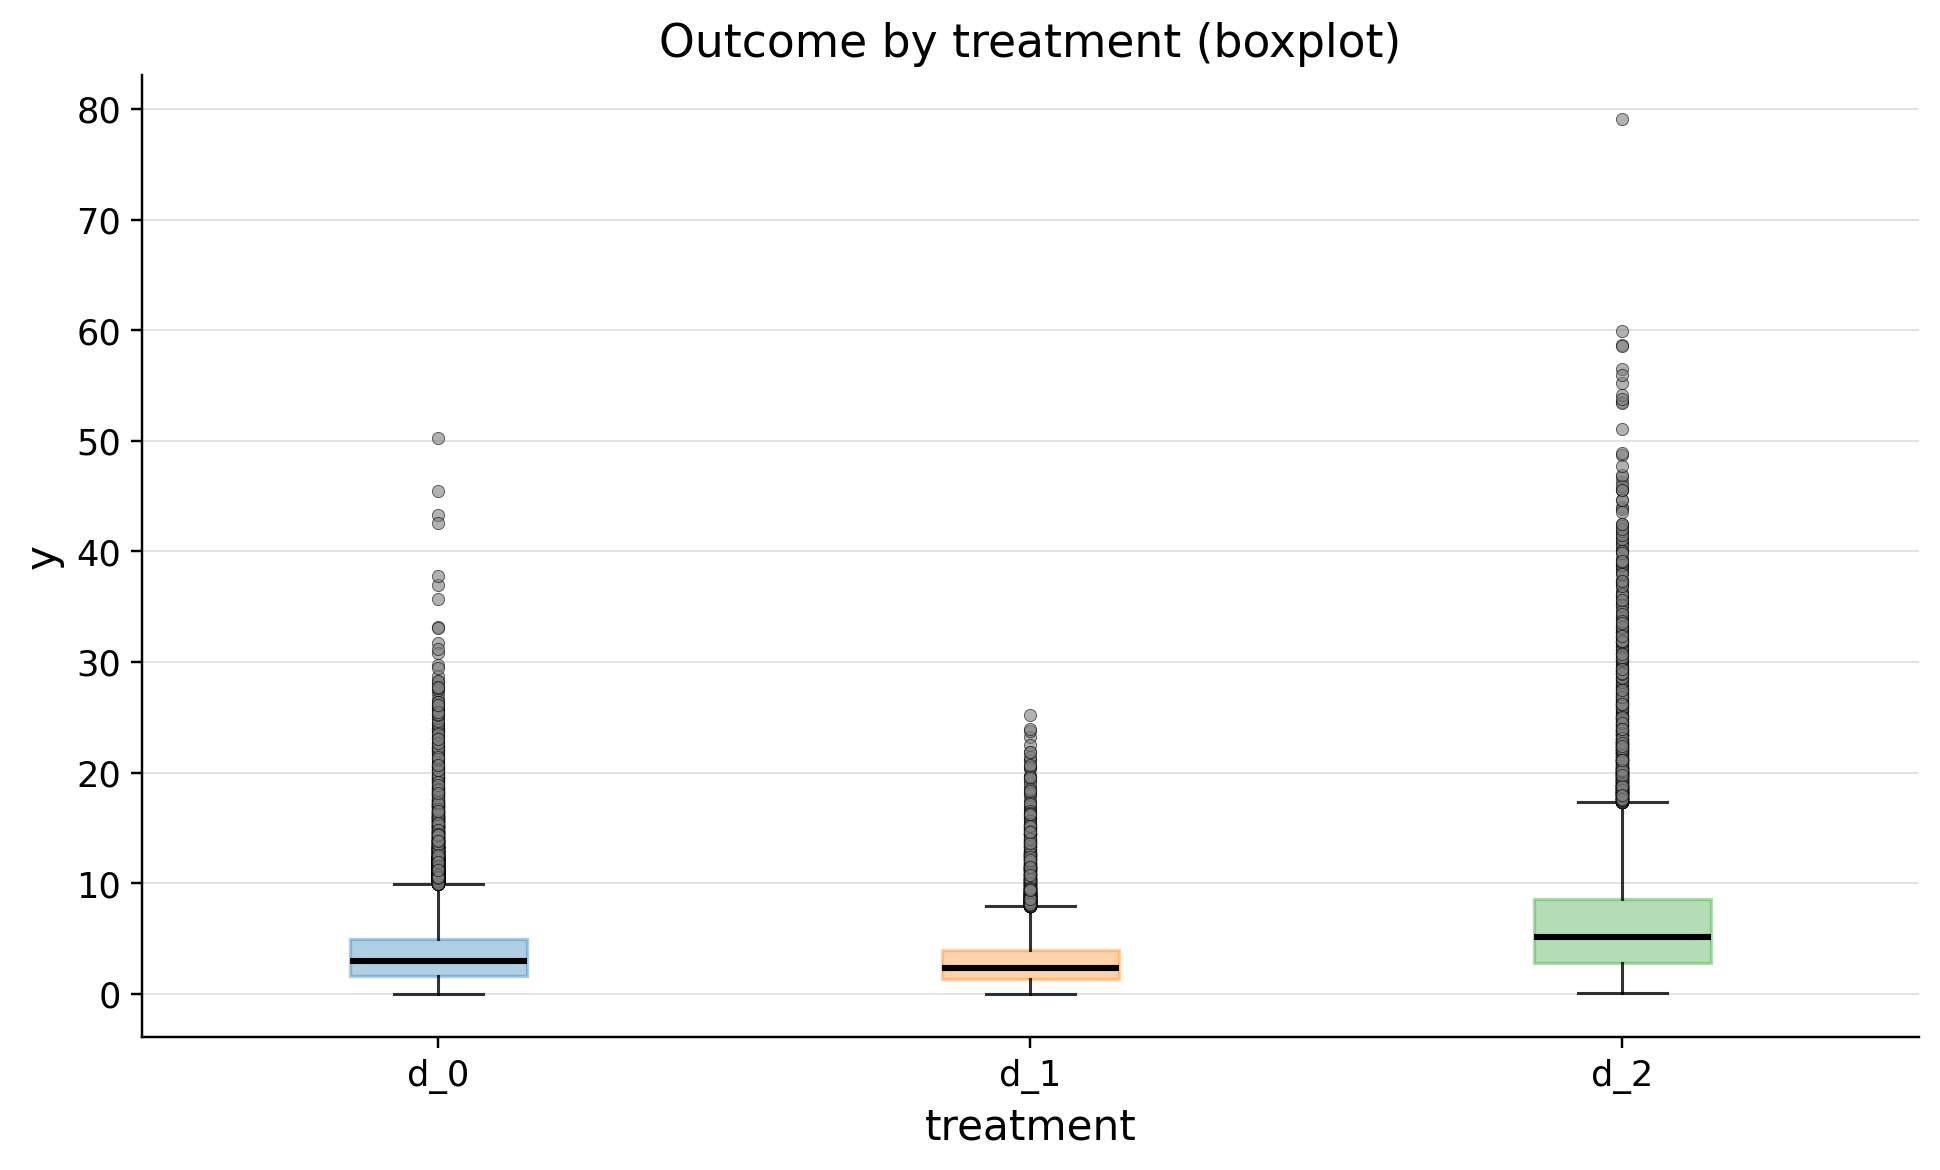

In [6]:
from causalis.shared import outcome_plot_boxplot

outcome_plot_boxplot(multi_causaldata)

In [7]:
from causalis.shared import outcome_outliers

outcome_outliers(multi_causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,d_0,50115,2288,0.045655,-3.370308,9.954048,True,iqr,both
1,d_2,25008,1173,0.046905,-5.938277,17.298826,True,iqr,both
2,d_1,24877,1067,0.042891,-2.652760,7.905997,True,iqr,both


In [8]:
from causalis.shared import confounders_balance

confounders_balance(multi_causaldata, 'd_0', 'd_2')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.217440,0.274072,0.056632,0.131823,0.00000
1,avg_sessions_week,4.827957,5.059494,0.231536,0.116747,0.00000
2,spend_last_month,82.894719,89.334021,6.439302,0.076205,0.00000
3,support_tickets_q,1.478140,1.569378,0.091238,0.073883,0.00000
4,discount_eligible,0.325870,0.356006,0.030136,0.063605,0.00000
5,urban_resident,0.585912,0.604687,0.018774,0.038256,0.00002
6,tenure_months,23.672462,23.391337,0.281125,-0.024131,0.00373
7,credit_utilization,0.449627,0.451855,0.002228,0.020493,0.02836


In [9]:
confounders_balance(multi_causaldata, 'd_0', 'd_1')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,avg_sessions_week,4.827957,5.330050,0.502092,0.253187,0.00000
1,premium_user,0.217440,0.296861,0.079421,0.182466,0.00000
2,tenure_months,23.672462,25.752063,2.079601,0.176703,0.00000
3,spend_last_month,82.894719,96.062898,13.168180,0.149709,0.00000
4,discount_eligible,0.325870,0.395626,0.069756,0.145642,0.00000
5,urban_resident,0.585912,0.638421,0.052509,0.107919,0.00000
6,support_tickets_q,1.478140,1.492302,0.014162,0.011558,0.47358
7,credit_utilization,0.449627,0.448996,0.000632,-0.005811,0.86692
